In [34]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import joblib

In [35]:
# Load the datasets
bike_sales = pd.read_excel('Bike_Sales.xlsx')
bike_sales_uganda = pd.read_excel('Bike_sales_Uganda.xlsx')

In [36]:
bike_sales.head(2)

,Date,Day,Month,Year,Customer_Age,Age_Group,Customer_Gender,Country,State,Product_Category,Sub_Category,Product,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
0,2017-01-01,1,January,2017,17,Youth (<25),M,Canada,British Columbia,Bikes,Road Bikes,"Road-250 Red, 44",2,1519,2443,1848,3038,4886
1,2017-01-01,1,January,2017,23,Youth (<25),M,Australia,Victoria,Bikes,Mountain Bikes,"Mountain-200 Black, 46",2,1252,2295,2086,2504,4590


In [37]:
bike_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113036 entries, 0 to 113035
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              113036 non-null  datetime64[ns]
 1   Day               113036 non-null  int64         
 2   Month             113036 non-null  object        
 3   Year              113036 non-null  int64         
 4   Customer_Age      113036 non-null  int64         
 5   Age_Group         113036 non-null  object        
 6   Customer_Gender   113036 non-null  object        
 7   Country           113036 non-null  object        
 8   State             113036 non-null  object        
 9   Product_Category  113036 non-null  object        
 10  Sub_Category      113036 non-null  object        
 11  Product           113036 non-null  object        
 12  Order_Quantity    113036 non-null  int64         
 13  Unit_Cost         113036 non-null  int64         
 14  Unit

In [38]:
bike_sales.describe()

,Date,Day,Year,Customer_Age,Order_Quantity,Unit_Cost,Unit_Price,Profit,Cost,Revenue
count,113036,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000,113036.000000
mean,2020-01-06 01:36:09.376127744,15.665753,2019.520153,35.919212,11.901660,267.296366,452.938427,372.681358,469.318695,842.000053
min,2017-01-01 00:00:00,1.000000,2017.000000,17.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000
25%,2019-01-09 00:00:00,8.000000,2019.000000,28.000000,2.000000,2.000000,5.000000,39.000000,28.000000,70.000000
50%,2019-10-16 00:00:00,16.000000,2019.500000,35.000000,10.000000,9.000000,24.000000,135.000000,108.000000,245.000000
75%,2021-01-28 00:00:00,23.000000,2021.000000,43.000000,20.000000,42.000000,70.000000,432.000000,432.000000,880.000000
max,2021-12-31 00:00:00,31.000000,2021.000000,87.000000,32.000000,2171.000000,3578.000000,26158.000000,42978.000000,69136.000000
std,NaN,8.781567,1.179704,11.021936,9.561857,549.835483,922.071219,595.080571,884.866118,1466.202934


In [44]:
bike_sales.shape

(113036, 18)

In [45]:
bike_sales.columns

Index(['Date', 'Day', 'Month', 'Year', 'Customer_Age', 'Age_Group',
       'Customer_Gender', 'Country', 'State', 'Product_Category',
       'Sub_Category', 'Product', 'Order_Quantity', 'Unit_Cost', 'Unit_Price',
       'Profit', 'Cost', 'Revenue'],
      dtype='object')

In [46]:
# Check for missing values
print("Missing values in each column of Bike_Sales:")
print(bike_sales.isnull().sum())

Missing values in each column of Bike_Sales:


Date                0
Day                 0
Month               0
Year                0
Customer_Age        0
Age_Group           0
Customer_Gender     0
Country             0
State               0
Product_Category    0
Sub_Category        0
Product             0
Order_Quantity      0
Unit_Cost           0
Unit_Price          0
Profit              0
Cost                0
Revenue             0
dtype: int64


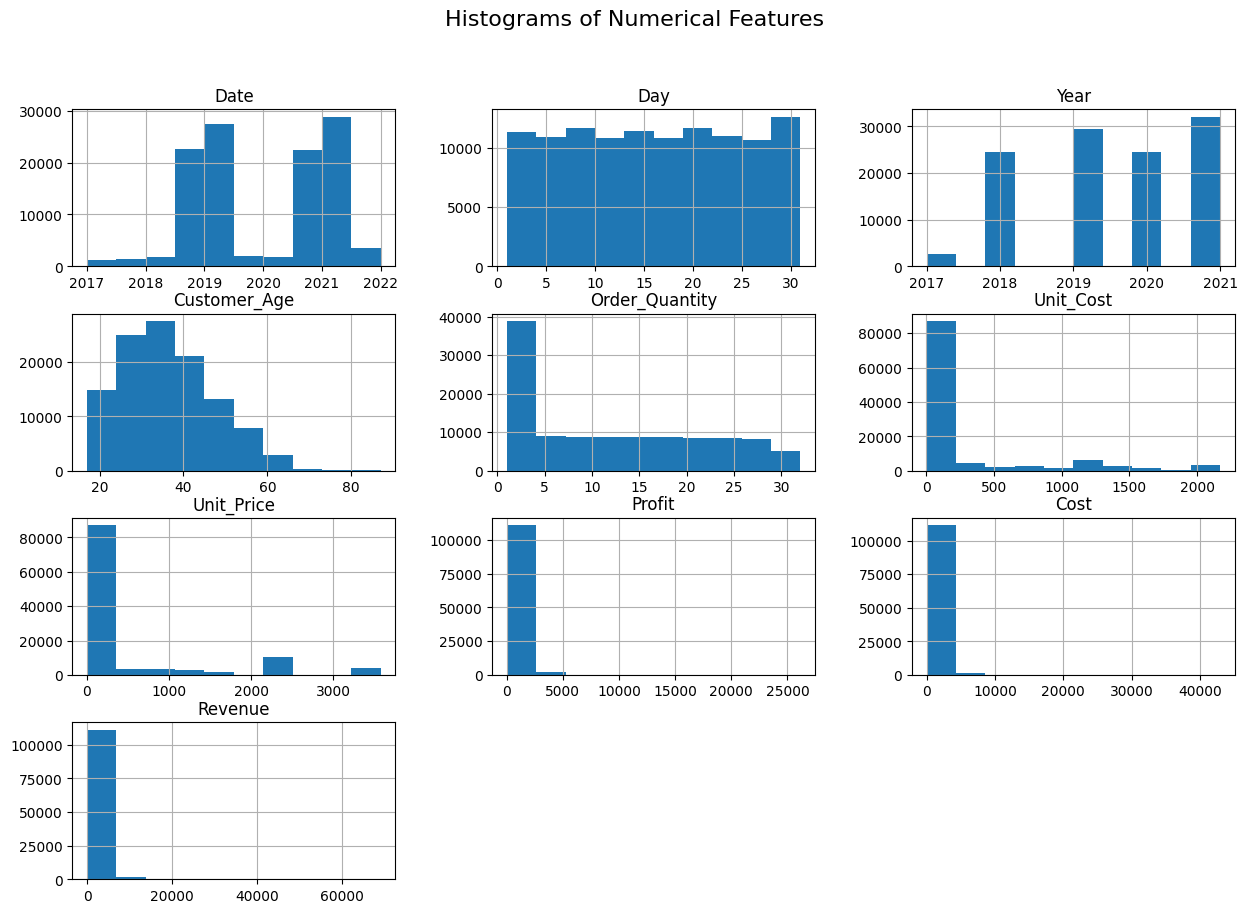

In [47]:
# Data Visualization
## Histograms
bike_sales.hist(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.show()

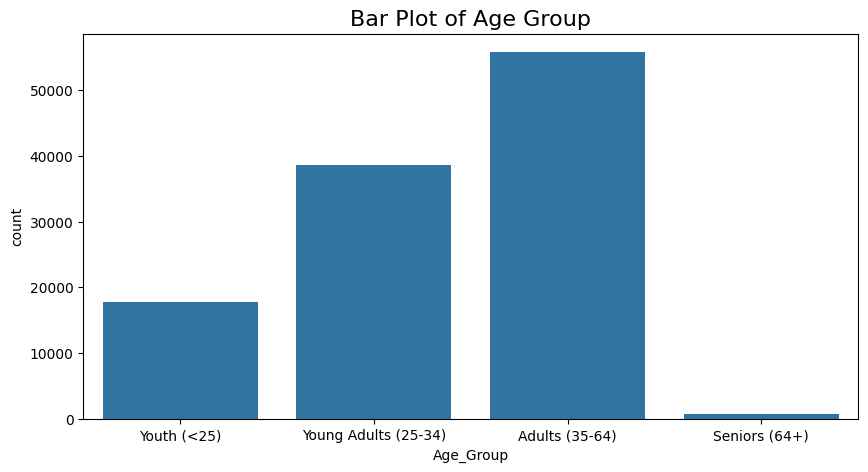

In [48]:
## Bar plots for categorical data
plt.figure(figsize=(10, 5))
sns.countplot(data=bike_sales, x='Age_Group')
plt.title('Bar Plot of Age Group', fontsize=16)
plt.show()

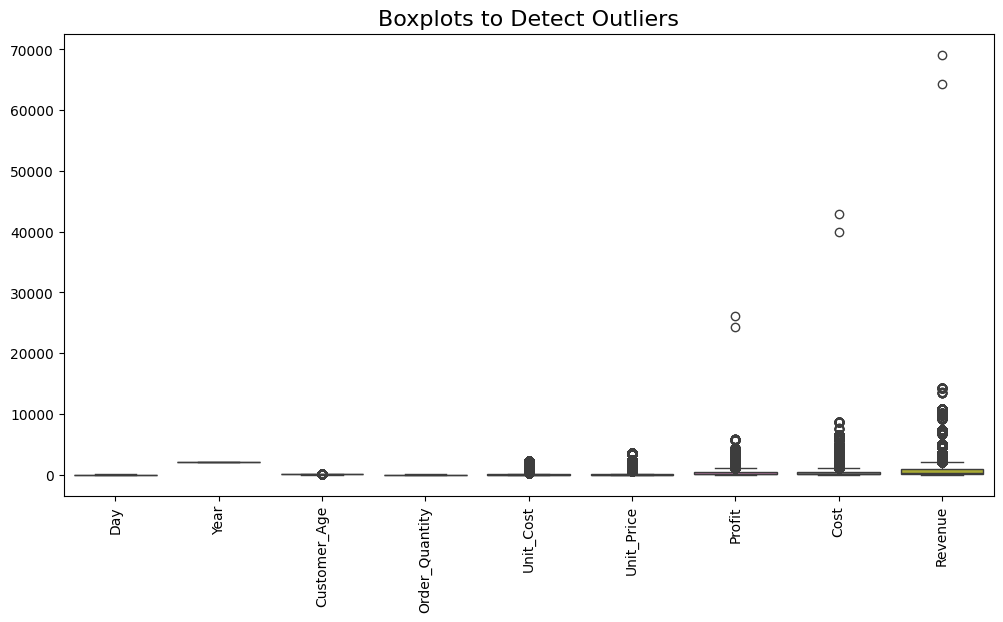

In [49]:
## Box plots
plt.figure(figsize=(12, 6))
sns.boxplot(data=bike_sales)
plt.xticks(rotation=90)
plt.title('Boxplots to Detect Outliers', fontsize=16)
plt.show()

In [50]:
def calculate_outlier_percentages(df, columns):
    """
    Calculate the percentage of outliers in each specified numeric column using the IQR method.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.

    Returns:
        dict: A dictionary with column names as keys and the percentage of outliers as values.
    """
    percentages = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        percentages[column] = percentage
    return percentages

def print_outlier_percentages(df, columns):
    """
    Print the percentage of outliers for each specified numeric column and calculate the overall percentage of outliers.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.
    """
    outlier_percentages = calculate_outlier_percentages(df, columns)
    total_outliers = 0
    total_data_points = df.shape[0] * len(columns)
    
    for column, percentage in outlier_percentages.items():
        print(f"Column '{column}' has {percentage:.2f}% outliers")
        total_outliers += (percentage / 100) * df.shape[0]
    
    overall_percentage = (total_outliers / total_data_points) * 100
    print(f"\nOverall percentage of outliers in the dataset: {overall_percentage:.2f}%")

# Load the training dataset
numerical_vars = bike_sales.select_dtypes(include=['number']).columns.tolist()

# Print outlier percentages
print_outlier_percentages(bike_sales, numerical_vars)


Column 'Day' has 0.00% outliers
Column 'Year' has 0.00% outliers
Column 'Customer_Age' has 0.47% outliers
Column 'Order_Quantity' has 0.00% outliers
Column 'Unit_Cost' has 22.99% outliers
Column 'Unit_Price' has 22.99% outliers
Column 'Profit' has 11.45% outliers
Column 'Cost' has 16.08% outliers
Column 'Revenue' has 14.58% outliers

Overall percentage of outliers in the dataset: 9.84%


In [51]:
def calculate_upper_bound(data, column):
    """
    Calculate the upper bound for a column using the IQR method.

    Args:
        data (pd.DataFrame): The dataframe containing the data.
        column (str): The column name for which to calculate the upper bound.

    Returns:
        float: The calculated upper bound.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    return upper_bound

def replace_outliers_with_upper_bound(df, columns):
    """
    Replace outliers in the specified columns with the upper bound.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        columns (list): List of column names to check for outliers.

    Returns:
        pd.DataFrame: The dataframe with outliers replaced.
    """
    df_cleaned = df.copy()
    for column in columns:
        upper_bound = calculate_upper_bound(df, column)
        df_cleaned[column] = df_cleaned[column].apply(lambda x: min(x, upper_bound))
    return df_cleaned

def calculate_outlier_percentages(df, columns):
    """
    Calculate the percentage of outliers in each specified numeric column using the IQR method.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.

    Returns:
        dict: A dictionary with column names as keys and the percentage of outliers as values.
    """
    percentages = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        percentage = (len(outliers) / len(df)) * 100
        percentages[column] = percentage
    return percentages

def print_outlier_percentages(df, columns):
    """
    Print the percentage of outliers for each specified numeric column and calculate the overall percentage of outliers.

    Args:
        df (pd.DataFrame): The dataframe to process.
        columns (list): List of column names to check for outliers.
    """
    outlier_percentages = calculate_outlier_percentages(df, columns)
    total_outliers = 0
    total_data_points = df.shape[0] * len(columns)
    
    for column, percentage in outlier_percentages.items():
        print(f"Column '{column}' has {percentage:.2f}% outliers")
        total_outliers += (percentage / 100) * df.shape[0]
    
    overall_percentage = (total_outliers / total_data_points) * 100
    print(f"\nOverall percentage of outliers in the dataset: {overall_percentage:.2f}%")


# Columns of interest
columns_with_outliers = ['Customer_Age', 'Unit_Cost', 'Unit_Price', 'Profit', 'Cost', 'Revenue']

# Replace outliers with the upper bound
bike_sales_data_cleaned = replace_outliers_with_upper_bound(bike_sales, columns_with_outliers)

# Calculate and print upper bounds for each column
upper_bounds = {column: calculate_upper_bound(bike_sales, column) for column in columns_with_outliers}

print("Upper bounds for the specified variables:")
for column, upper_bound in upper_bounds.items():
    print(f"{column}: {upper_bound}")

# Check the outlier percentages after the replacement of the upper bounds
print("\nOutlier percentages after replacement with upper bounds:")
print_outlier_percentages(bike_sales_data_cleaned, columns_with_outliers)


Upper bounds for the specified variables:
Customer_Age: 65.5
Unit_Cost: 102.0
Unit_Price: 167.5
Profit: 1021.5
Cost: 1038.0
Revenue: 2095.0

Outlier percentages after replacement with upper bounds:
Column 'Customer_Age' has 0.00% outliers
Column 'Unit_Cost' has 0.00% outliers
Column 'Unit_Price' has 0.00% outliers
Column 'Profit' has 0.00% outliers
Column 'Cost' has 0.00% outliers
Column 'Revenue' has 0.00% outliers

Overall percentage of outliers in the dataset: 0.00%


In [52]:
# Save the cleaned dataset as "Sentongo.xlsx"
output_filename = "Sentongo.xlsx"
bike_sales_data_cleaned.to_excel(output_filename, index=False)

print(f"Cleaned dataset saved as {output_filename}")

Cleaned dataset saved as Sentongo.xlsx
